## 1.Join the data from Part 1 with the data from Part 2 to create a new dataframe.

#### Here I have merged dataframes obtained from Part1 (citybikes API) and Part2 ( Foursquare and Yelp API)

In [1]:
import requests
import pandas as pd
import os
import json
stations_df = pd.read_csv('../data/citybikes_stations.csv')    #Data from Part1
venues_df= pd.read_csv('../data/correct_foursquare_venues.csv') #Data from Part2 - Foursquare
restaurants_df=pd.read_csv('../data/correct_yelp_restaurants.csv') # Data from Part2 -Yelp

merged_df_r = pd.merge(stations_df, restaurants_df, on=('Latitude','Longitude')) #merge citybikes and Yelp data using latitude and longitude
merged_df_v = pd.merge(stations_df, venues_df, on=('Latitude','Longitude')) #merge citybikes and Foursquare data using latitude and longitude

#### Plot1 : In below graph I am trying to relate 'Bikes Available' and 'Rating' so that I can understand if Bike stations near restaurants having high rating have less free bikes using merged_df_r dataframe

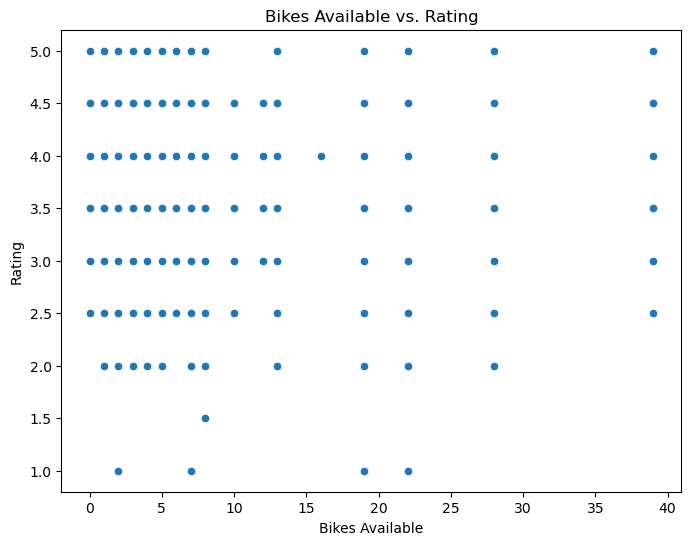

In [2]:
# Scatter plot for Bikes Available vs. Rating
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Bikes Available', y='Rating', data=merged_df_r)
plt.title('Bikes Available vs. Rating')
plt.xlabel('Bikes Available')
plt.ylabel('Rating')
plt.savefig("../images/Plot1.png") 
plt.show()

### Observation:
#### there are less bikes available near restaurants having low rating

#### Below code is to get 
1. General information about average of 'Bikes Available' and 'Empty Slots' according to Categories
2. Calculate number of Stations where credit card is accepted and where only cash is accepted

In [3]:
# Average bikes available and empty slots by category
category_stats = merged_df_r.groupby('Categories').agg({'Bikes Available': 'mean', 'Empty Slots': 'mean'})
print(category_stats)

# Number of bike stations with banking service
print("Number of Bike Stations with Banking Service:", merged_df_r[merged_df_r['Banking'] == True]['Banking'].count())
print("Number of Bike Stations with No Banking Service:", merged_df_r[merged_df_r['Banking'] == False]['Banking'].count())



                                                  Bikes Available  Empty Slots
Categories                                                                    
American (Traditional)                                       4.00         16.0
American (Traditional), Burgers                              7.00         38.0
American (Traditional), Wine Bars, Cocktail Bars            10.00         48.0
Auvergnat                                                    4.00         15.0
Bagels, American (Traditional)                              39.00          2.0
...                                                           ...          ...
Vietnamese                                                   7.00         27.0
Wine Bars, Bistros                                          12.25         15.5
Wine Bars, Cafes                                             8.00         27.0
Wine Bars, French                                            5.50         14.0
Yoga, Cafes                                         

## 2.Provide a visualization that you used as part of your EDA process. Explain the initial pattern or relationship you discoved through this visualization. 

#### Below I am trying to get Occupancy % of Bike Stations by calculating difference between total slots and empty slots (assuming less empty slots corresponding to more crowd in that area) around each category of restaurant
This data can suggest generally which kind of restaurants are crowded or has more scope of business if someone wants to open a new restaurant


In [4]:
#Check occupancy percentage accprding to Categories assuming less empty slots corresponding to more people
Total_slots = merged_df_r.groupby('Categories')['Slots'].sum()
emptyslots = merged_df_r.groupby('Categories')['Empty Slots'].sum()

Occupancy = (abs(Total_slots - emptyslots) / Total_slots) * 100

Sorted_Occupancy=Occupancy.sort_values(ascending=False)

top_10_busy_categories=Sorted_Occupancy[:10]
top_10_busy_categories

Categories
French, Lounges                               95.348837
Breakfast & Brunch                            95.348837
Bars, Modern European                         95.348837
Chimney Cakes, Cafes, Coffee & Tea            95.348837
Tex-Mex                                       95.348837
Cuban, Cocktail Bars, Tapas Bars              95.348837
Cajun/Creole, Cocktail Bars                   95.348837
Spanish, Tapas Bars                           95.348837
Bakeries, Breakfast & Brunch, Coffee & Tea    95.348837
Bistros, Coffee & Tea, Cafes                  95.348837
dtype: float64

### Plot2:
- First I captured Occupancy details at Bike stations where Credit Card is accepted (i.e. Banking = True) around each of the Categories(type of restaurants/businesses)
- Then I captured Occupancy details at Bike stations where Cash is accepted (i.e. Banking = False) around each of the Categories(type of restaurants/businesses)

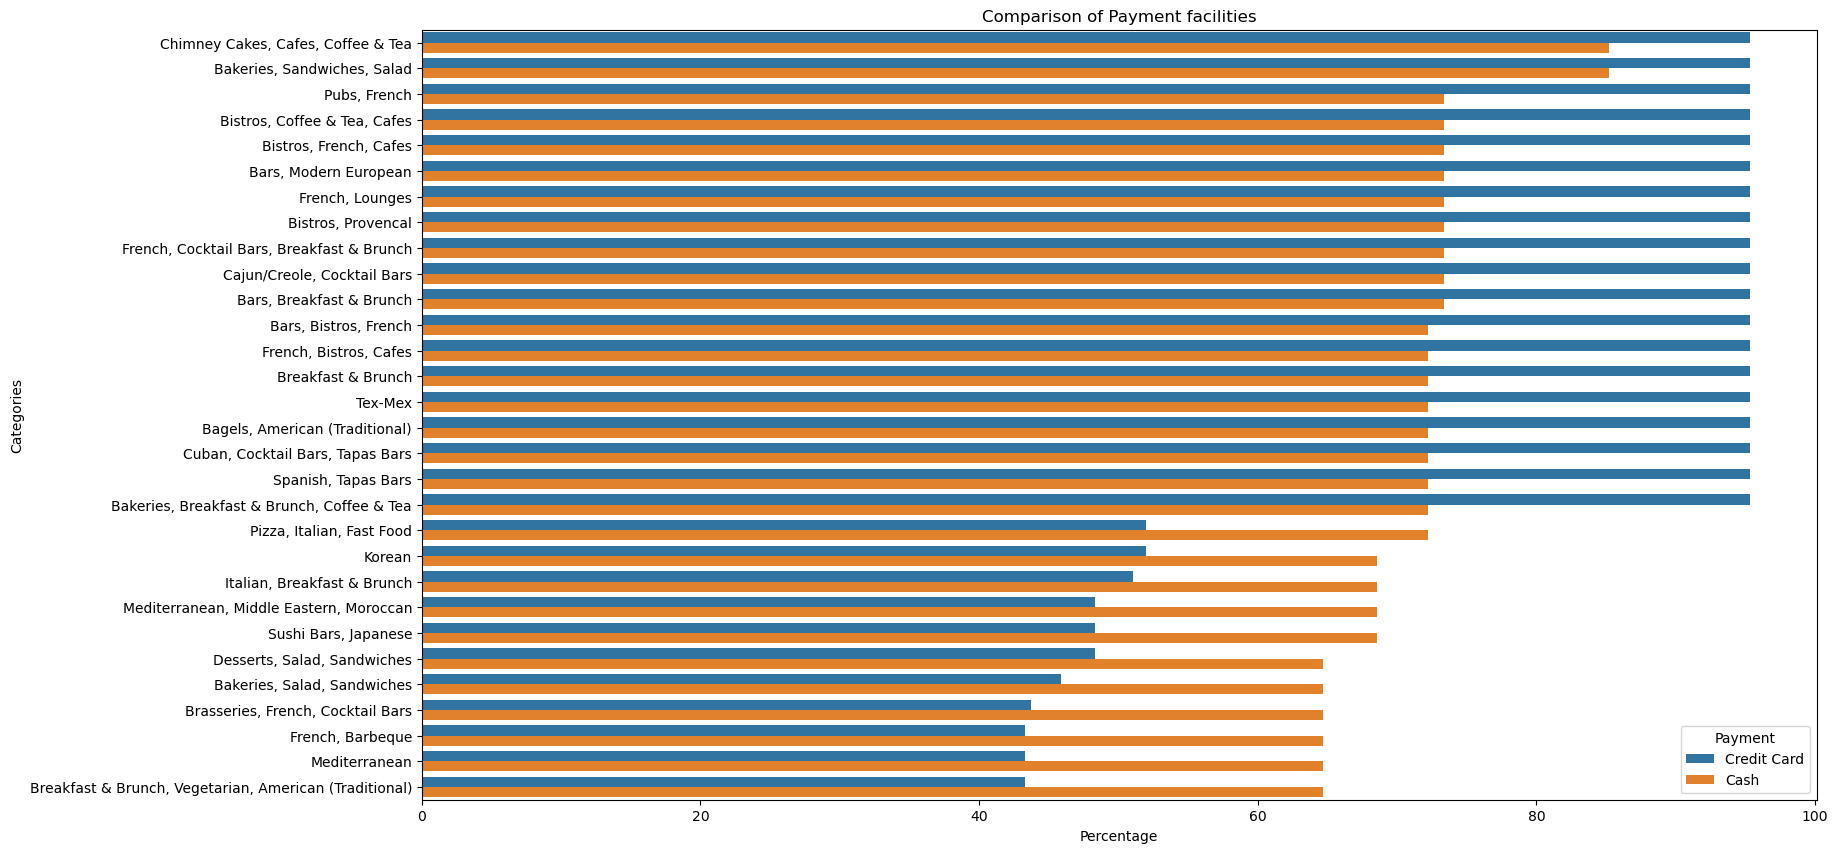

In [5]:
#Checking Occupancy based on payment facilities

Banking=merged_df_r[merged_df_r['Banking']==True]  #where credit card is accepted
Cash=merged_df_r[merged_df_r['Banking']==False]    #cash

# Calculation to find percentage Occupancy
Total_slots_b = Banking.groupby('Categories')['Slots'].sum()                 
emptyslots_b = Banking.groupby('Categories')['Empty Slots'].sum()
percentage_difference_b = (abs(Total_slots_b - emptyslots_b) / Total_slots_b) * 100

Total_slots_c = Cash.groupby('Categories')['Slots'].sum()
emptyslots_c = Cash.groupby('Categories')['Empty Slots'].sum()
percentage_difference_c = (abs(Total_slots_c - emptyslots_c) / Total_slots_c) * 100


## Limiting number of categories (top 20) for better plot
Most_occupied=percentage_difference_b.sort_values(ascending=False) #most occupied categories where credit card is accepted
Most_occupied=Most_occupied[:30]

Most_occupied_c=percentage_difference_c.sort_values(ascending=False) #most occupied categories where cash is accepted
Most_occupied_c=Most_occupied_c[:30]


#Code to plot graph according to payment facilities at Bike stations near Categories of Restaurant which are crowded/busy
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.DataFrame({
    'Categories': Most_occupied.index,
    'Credit Card': Most_occupied.values,
    'Cash': Most_occupied_c.values
})

# Melt the DataFrame to create a long-form version suitable for plotting
df_melted = df.melt(id_vars='Categories', var_name='Payment', value_name='Percentage')

# Create a bar plot using Seaborn
plt.figure(figsize=(18, 10))
sns.barplot(x='Percentage', y='Categories', hue='Payment', data=df_melted, orient='h')
plt.xlabel('Percentage')
plt.ylabel('Categories')
plt.title('Comparison of Payment facilities')
plt.savefig("../images/Plot2.png") 
plt.show()

## Observation:
Above graph suggests that Restaurants (in mentioned Categories) near Bike Stations with Credit Card payment facility are more occupied than stations where only cash is accepeted.


### Plot3:
#### Same observations about Occupancy % I tried to achieve with respect to Rating of restaurants, number of reviews for restaurants and price category of restaurants (€=cheap ; €€=medium; €€€=expensive; €€€€=luxury)

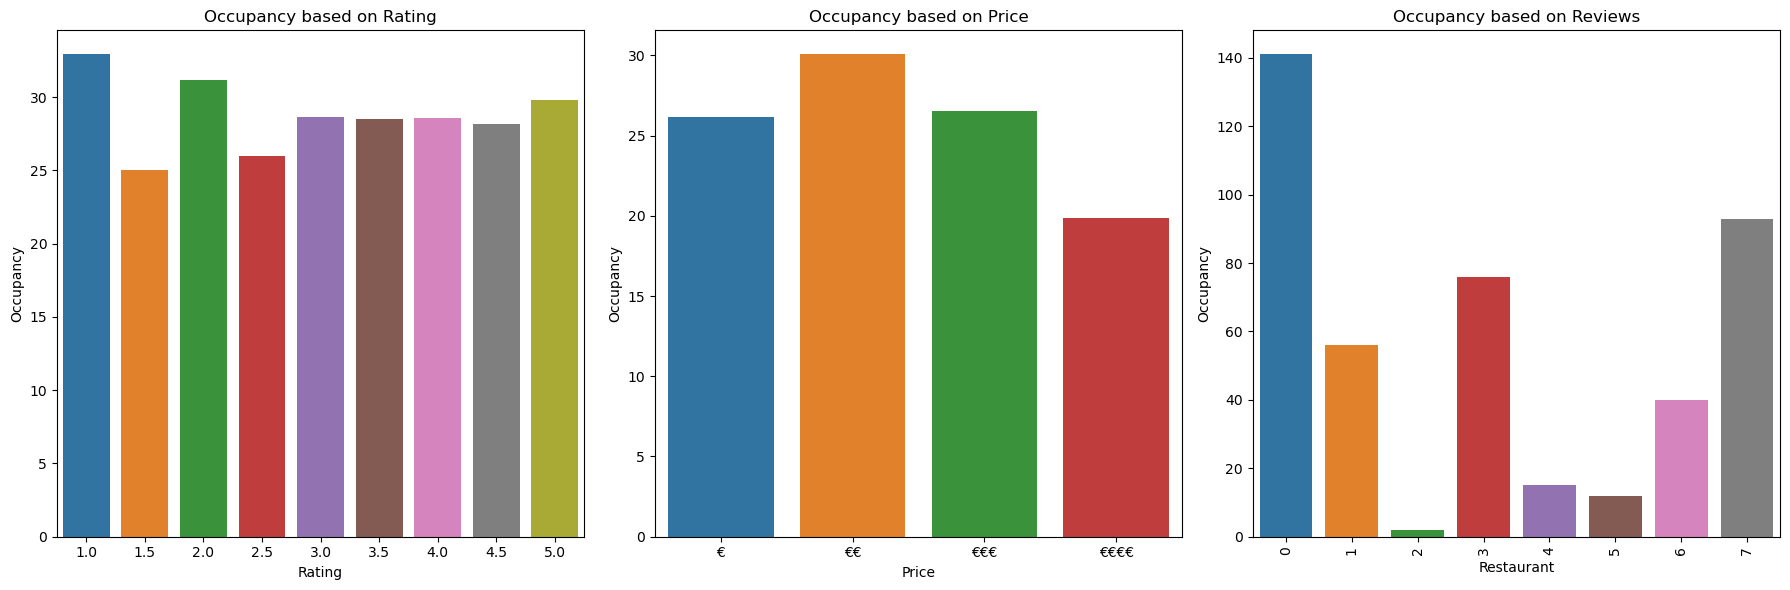

In [6]:
#Occupancy based on Rating,Review and Price

grouped_slots_r = merged_df_r.groupby('Rating')['Slots'].sum()              #Occupancy % by Rating
grouped_emptyslots_r = merged_df_r.groupby('Rating')['Empty Slots'].sum()
percentage_difference_r = (abs(grouped_slots_r - grouped_emptyslots_r) / grouped_slots_r) * 100
percentage_difference_r.sort_values(ascending=False)
grouped_emptyslots_r.sort_values(ascending=False)

grouped_slots_p = merged_df_r.groupby('Price')['Slots'].sum()              #Occupancy % by Price
grouped_emptyslots_p = merged_df_r.groupby('Price')['Empty Slots'].sum()
percentage_difference_p = (abs(grouped_slots_p - grouped_emptyslots_p) / grouped_slots_p) * 100
percentage_difference_p.sort_values(ascending=False)

reviews=merged_df_r.sort_values('Reviews', ascending=False)                #Occupancy % by Reviews
reviews=reviews[:20]
grouped_slots_re = reviews.groupby('Name_x')['Slots'].sum()
grouped_emptyslots_re = reviews.groupby('Name_x')['Empty Slots'].sum()
percentage_difference_re = (abs(grouped_slots_re - grouped_emptyslots_re) / grouped_slots_re) * 100
percentage_difference_re.sort_values(ascending=False)


import matplotlib.pyplot as plt
import seaborn as sns


# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Occupancy based on Rating
sns.barplot(x=percentage_difference_r.index, y=percentage_difference_r.values, ax=axes[0])
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Occupancy')
axes[0].set_title('Occupancy based on Rating')

# Plot 2: Occupancy based on Price
sns.barplot(x=percentage_difference_p.index, y=percentage_difference_p.values, ax=axes[1])
axes[1].set_xlabel('Price')
axes[1].set_ylabel('Occupancy')
axes[1].set_title('Occupancy based on Price')

# Plot 3: Occupancy based on 'Reviews'
sns.barplot(x=grouped_emptyslots_re.index, y=grouped_emptyslots_re.values, ax=axes[2])
axes[2].set_xticklabels(axes[2].get_xticks(), rotation=90)
axes[2].set_xlabel('Restaurant')
axes[2].set_ylabel('Occupancy')
axes[2].set_title('Occupancy based on Reviews')

# Adjust layout
plt.tight_layout()
plt.savefig("../images/Plot3.png")
# Show the plots
plt.show()


## OBSERVATION
Above Analysis shows that 
- Occupancy based on rating,Reviews and Price suggests that people prefer to go where price is reasonable and high number of reviews over rating.
- Less occupancy of bikes around expensive restaurants suggest that people going to such restaurants prefer car or other vehicle.

# Database

Put all your results in an SQLite3 database (remember, SQLite stores its databases as files in your local machine - make sure to create your database in your project's data/ directory!)

Below is the code to create database using dataframes obtained from Part1(citybikes API) and Part2(Foursquare and Yelp API)

In [9]:
import sqlite3
import csv

# Connect to the SQLite database (or create it if it doesn't exist)
conn = sqlite3.connect('../data/Around_BikeRentals.db')

# Create a cursor object using the cursor() method
cursor = conn.cursor()

cursor.execute('''CREATE TABLE IF NOT EXISTS Bike_Stations(
    Name TEXT NOT NULL,
    Latitude FLOAT NOT NULL,
    Longitude FLOAT NOT NULL,
    Bikes_Available INTEGER,
    Slots INTEGER,
    Empty_Slots INTEGER,
    Banking BOOLEAN,
    Ebikes INTEGER,
    PRIMARY KEY (Latitude, Longitude))'''
              )

# reading data from the CSV file
with open('../data/citybikes_stations.csv') as f:
   reader = csv.reader(f)
   data = list(reader)
    
# inserting data into the table
for row in data:
   cursor.execute("INSERT INTO Bike_Stations (Name, Latitude,Longitude,Bikes_Available,Slots,Empty_Slots,Banking,Ebikes) values (?, ?,?,?,?,?,?,?)", row)

conn.commit()


IndentationError: unexpected indent (944308417.py, line 11)

In [30]:
cursor.execute('''CREATE TABLE IF NOT EXISTS Foursquare_Venues(
    Name TEXT NOT NULL,
    Category TEXT,
    Closed_Bucket STRING,
    Distance INTEGER,
    Latitude FLOAT NOT NULL,
    Longitude FLOAT NOT NULL,
    FOREIGN KEY (Latitude, Longitude) REFERENCES Bike_Stations(Latitude, Longitude))''')
# reading data from the CSV file
with open('../data/correct_foursquare_venues.csv') as f:
   reader = csv.reader(f)
   data = list(reader)
    
# inserting data into the table
for row in data:
   cursor.execute("INSERT INTO Foursquare_Venues (Name, Category,Closed_Bucket,Distance,Latitude,Longitude) values (?, ?,?,?,?,?)", row)
conn.commit()

Look at the data before and after the join to validate your data.

In [17]:
# reading data from the CSV file
with open('correct_foursquare_venues.csv') as f:
   reader = csv.reader(f)
   data = list(reader)
    
# inserting data into the table
for row in data:
   cursor.execute("INSERT INTO Foursquare_Venues (Name, Category,Closed_Bucket,Distance,Latitude,Longitude) values (?, ?,?,?,?,?)", row)

conn.commit()

In [31]:
cursor.execute('''CREATE TABLE IF NOT EXISTS Yelp_Restuarants(
    Name TEXT NOT NULL,
    Categories TEXT,
    Rating FLOAT,
    Address TEXT,
    Res_Latitude FLOAT,
    Res_Longitude FLOAT,
    Reviews INTEGER,
    Distance INTEGER,
    Phone VARCHAR(12),
    Closed BOOLEAN,
    Price STRING,
    Latitude FLOAT NOT NULL,
    Longitude FLOAT NOT NULL,
    FOREIGN KEY (Latitude, Longitude) REFERENCES Bike_Stations(Latitude, Longitude))
    ''')
# reading data from the CSV file
with open('../data/correct_yelp_restaurants.csv') as f:
   reader = csv.reader(f)
   data = list(reader)
    
# inserting data into the table
for row in data:
   cursor.execute("INSERT INTO Yelp_Restuarants (Name, Categories,Rating,Address,Res_Latitude,Res_Longitude,Reviews,Distance,Phone,Closed,Price,Latitude,Longitude) values (?, ?,?,?,?,?,?,?,?,?,?,?,?)", row)

conn.commit()

## NOTE: I have created composite primary key (Latitude,Longitude) in Bike_stations table and Foreign key on same columns in Yelp_Restuarants and Foursquare_Venues

# Query to check stations and bikes near famous restaurants (as per reviews)
select yr.Name as Reataurant,Reviews,Rating,Distance,bs.Name as Station,Empty_Slots,Bikes_Available from Yelp_Restuarants as yr
JOIN Bike_Stations AS bs ON yr.Latitude = bs.Latitude AND yr.Longitude = bs.Longitude
order by Reviews Desc limit 20;


SELECT * FROM Foursquare_Venues AS fv
JOIN Bike_Stations AS bs ON fv.Latitude = bs.Latitude AND fv.Longitude = bs.Longitude;

SELECT * FROM Yelp_Restuarants AS yr
JOIN Bike_Stations AS bs ON yr.Latitude = bs.Latitude AND yr.Longitude = bs.Longitude;
